In [33]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from isbnlib import meta
from isbnlib.registry import bibformatters

from operator import itemgetter

from community import community_louvain
import matplotlib.cm as cm

In [85]:
data = pd.read_csv('data/rec-amz-Books.edges', header=None)
data

,0,1,2,3
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200
...,...,...,...,...
22507150,A20KO0BPMNREJL,B00M13FNSS,5.0,1406073600
22507151,A1BQO66R6OLCCW,B00M13FNSS,5.0,1406073600
22507152,A1CI87FHKK6HVC,B00M13FNSS,5.0,1406073600
22507153,A8W4BR3HGGS3C,B00M13FNSS,5.0,1406073600


In [4]:
#vyberame prvych n riadkov ...
n = 200000
data_sample = data.iloc[:n,0:3]
B = nx.Graph()
B.add_nodes_from(data_sample[0], bipartite=0)
B.add_nodes_from(data_sample[1],bipartite=1)
B.add_weighted_edges_from(data_sample.apply(tuple, axis=1))

In [86]:
bipartite.is_bipartite(B)

True

In [5]:
G_knihy = bipartite.projected_graph(B, data_sample[1])

In [ ]:
G_rec = bipartite.projected_graph(B, data_sample[0])

In [94]:
#kompletnost grafu, hustota
#print("hustota recenzentov:", nx.density(G_rec))
print("hustota knih:", nx.density(G_knihy))

hustota knih: 0.0009871421887081221


In [ ]:
#najkratsia vzdialenost medzi 2ma vrcholmi
#path1 = nx.shortest_path(G_knihy, source="0002247399", target="0002007770")
#print("Shortest path:", path1)

In [95]:
#je graf jeden komponent?
print("je bipartitný graf, pôvodný graf, 1 komponent? :",  nx.is_connected(B))
print("------------")
#print("je graf recenzorov 1 komponent? : ",  nx.is_connected(G_rec))
print("je graf kníh 1 komponent? : ",  nx.is_connected(G_knihy))

je bipartitný graf, pôvodný graf, 1 komponent? : False
------------
je graf kníh 1 komponent? :  False


In [96]:
komponenty_knih = nx.connected_components(G_knihy)
najvacsi_kom_knih = max(komponenty_knih, key=len)
G_knihy_najvacsi_kom = G_knihy.subgraph(najvacsi_kom_knih)
print("diameter najvacsieho komponentu knih:", nx.diameter(G_knihy_najvacsi_kom))

diameter najvacsieho komponentu knih: 12


In [ ]:
print("zhlukovy koeficient knih:", nx.transitivity(G_knihy))

Na prednáške sme brali tieto typy centralít: eigenvector, katz, pagerank, closeness, betweenness
Networkx ponúka okrem tých vyššie ešte aj: degree, hubs and authorities, prestige
Zatiaľ som spravila: degree, betweenness, eigenvectors

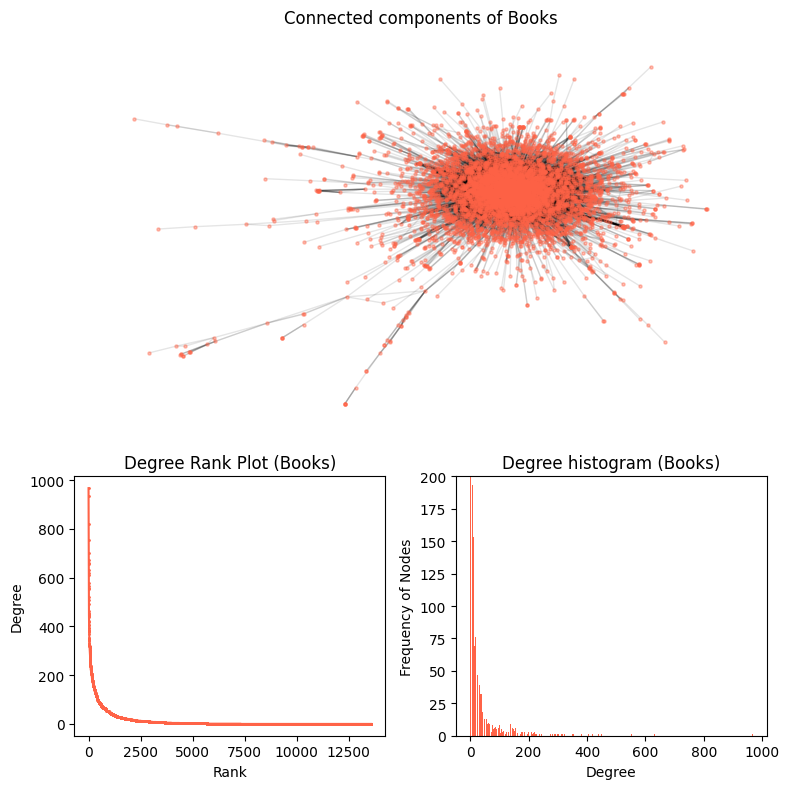

In [97]:
#stupne vrcholov
degree_sequence = sorted([d for n, d in G_knihy.degree()], reverse=True)

Gcc = G_knihy.subgraph(sorted(nx.connected_components(G_knihy), key=len, reverse=True)[0])

fig = plt.figure("Degree of the books", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Books")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, marker="o", markersize=1, color='tomato')
ax1.set_title("Degree Rank Plot (Books)")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color='tomato')
ax2.set_title("Degree histogram (Books)")
ax2.set_xlabel("Degree")
ax2.set_ylim([0, 200])
ax2.set_ylabel("Frequency of Nodes")

fig.tight_layout()
plt.show()

In [73]:
def from_ISBN_to_title(column):
    new_col = list()
    SERVICE = "openl"
    bibtex = bibformatters["json"]
    for value in column:
        isbn = str(value)
        book_data = json.loads(bibtex(meta(isbn, SERVICE)))
        #print(book_data["title"])
        new_col.append(book_data["title"])
    return new_col

In [108]:
#degree centrality
stupne_knih = nx.degree_centrality(G_knihy)
stupne_knih = sorted(stupne_knih.items(), key=lambda x:x[1], reverse=True)[:10]
stupne_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Degree centrality'])
stupne_knih_df['Book ISBN'] = [t[0] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = [t[1] for t in stupne_knih]
stupne_knih_df['Degree centrality'] = stupne_knih_df['Degree centrality'].apply(lambda x: round(x, 3))
stupne_knih_df['Book title'] = from_ISBN_to_title(stupne_knih_df['Book ISBN'])
stupne_knih_df

,Book ISBN,Book title,Degree centrality
0,0060098902,The Great Gatsby,0.071
1,0007124015,The Lord of the Rings,0.069
2,0060194995,To kill a mockingbird,0.060
3,0002007770,Water for Elephants,0.056
4,0007167040,Seabiscuit,0.052
5,0007386648,Unbroken: an extraordinary true story of coura...,0.049
6,0020519109,The Old Man and the Sea (A Scribner Classic),0.049
7,0060175966,The professor and the madman - a tale of murde...,0.048
8,0007172826,Girl with a Pearl Earring,0.046
9,0007149824,The Yiddish Policemen's Union,0.046


In [109]:
#eigenvector centrality
eigenvector_knihy = nx.eigenvector_centrality(G_knihy)
sorted_eigenvector_knihy = sorted(eigenvector_knihy.items(), key=itemgetter(1), reverse=True)[:10]
eigenvector_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Eigenvector centrality'])
eigenvector_knih_df['Book ISBN'] = [t[0] for t in sorted_eigenvector_knihy]
eigenvector_knih_df['Eigenvector centrality'] = [t[1] for t in stupne_knih]
eigenvector_knih_df['Eigenvector centrality'] = eigenvector_knih_df['Eigenvector centrality'].apply(lambda x: round(x, 3))
eigenvector_knih_df['Book title'] = from_ISBN_to_title(eigenvector_knih_df['Book ISBN'])

eigenvector_knih_df

,Book ISBN,Book title,Eigenvector centrality
0,0007149824,The Yiddish Policemen's Union,0.071
1,0060098902,The Great Gatsby,0.069
2,0002007770,Water for Elephants,0.060
3,0060004878,Live by night,0.056
4,0060194995,To kill a mockingbird,0.052
5,0007124015,The Lord of the Rings,0.049
6,0007167040,Seabiscuit,0.049
7,0007172826,Girl with a Pearl Earring,0.048
8,000721278X,Constant Princess,0.046
9,0060198303,The burglar on the prowl,0.046


In [114]:
#betweenness centrality
betweenness_knihy = nx.betweenness_centrality(G_knihy)
sorted_betweenness_knihy = sorted(betweenness_knihy.items(), key=itemgetter(1), reverse=True)[:10]
betweenness_knih_df = pd.DataFrame(columns=['Book ISBN', 'Book title', 'Betweenness centrality'])
betweenness_knih_df['Book ISBN'] = [t[0] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = [t[1] for t in sorted_betweenness_knihy]
betweenness_knih_df['Betweenness centrality'] = betweenness_knih_df['Betweenness centrality'].apply(lambda x: round(x, 3))
betweenness_knih_df['Book title'] = from_ISBN_to_title(betweenness_knih_df['Book ISBN'])
betweenness_knih_df

,Book ISBN,Book title,Betweenness centrality
0,0007124015,The Lord of the Rings,0.015
1,0060098902,The Great Gatsby,0.013
2,0007386648,Unbroken: an extraordinary true story of coura...,0.009
3,0060194995,To kill a mockingbird,0.009
4,0002007770,Water for Elephants,0.008
5,0007167040,Seabiscuit,0.007
6,0060175966,The professor and the madman - a tale of murde...,0.006
7,0020519109,The Old Man and the Sea (A Scribner Classic),0.005
8,0026009102,The fountainhead,0.005
9,0060175400,The poisonwood Bible - a novel,0.005


/var/folders/c2/k13xb47j4r13t6yhdv6xv15c0000gn/T/ipykernel_88938/2939858666.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar', max(partition_knihy.values()) + 1)


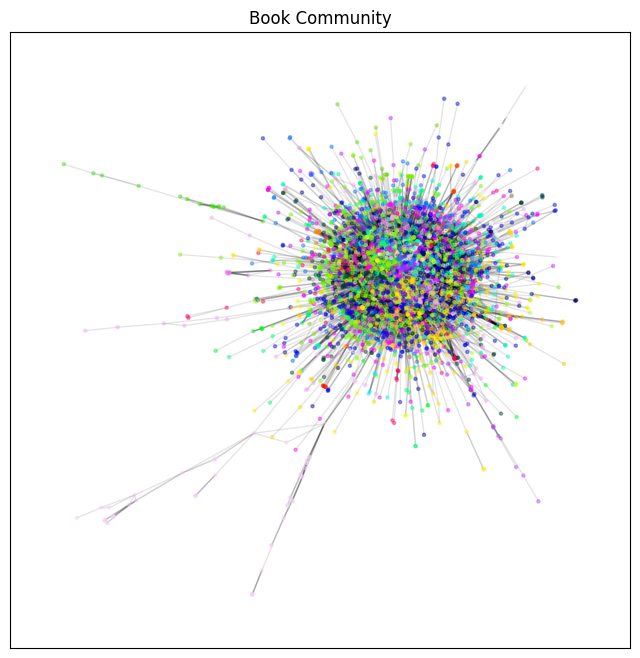

In [93]:
#vyberieme najvacsi komponent
Gcc = G_knihy.subgraph(sorted(nx.connected_components(G_knihy), key=len, reverse=True)[0])

#zadelime do komunit podla Louvian method
partition_knihy = community_louvain.best_partition(Gcc)

#zafarbime podla komunit
cmap = cm.get_cmap('gist_ncar', max(partition_knihy.values()) + 1)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_knihy.keys(), node_size=5, alpha=0.4, cmap=cmap, node_color=list(partition_knihy.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Book Community")
plt.show()